In [1]:
# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model  
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array 
from tensorflow.keras.applications.vgg16 import preprocess_input 

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [3]:
#Class to load the dataset images from device

class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))

In [5]:
import cv2
import numpy as np

# Class Preprocessor 
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image, apply Sobel filtering, and perform Watershed segmentation
    def preprocess(self, image):
        """
        :param image: Image
        :return: Processed image
        """
        # Step 1: Resize the image to a fixed size (ignoring the aspect ratio)
        resized_image = cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

        # Step 2: Apply Sobel filtering to detect edges
        sobel_x = cv2.Sobel(resized_image, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(resized_image, cv2.CV_64F, 0, 1, ksize=3)
        sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
        sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)

        # Step 3: Convert to grayscale and threshold the image for Watershed
        gray_image = cv2.cvtColor(sobel_magnitude, cv2.COLOR_BGR2GRAY)
        _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Step 4: Perform distance transform and normalize it
        dist_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 5)
        normalized_dist = cv2.normalize(dist_transform, None, 0, 1.0, cv2.NORM_MINMAX)

        # Step 5: Threshold the distance transformed image to create markers
        _, markers = cv2.threshold(normalized_dist, 0.5, 1.0, 0)
        markers = np.uint8(markers * 255)

        # Step 6: Perform connected components analysis
        _, markers = cv2.connectedComponents(markers)
        
        # Add one to all labels so that sure background is not 0, but 1
        markers = markers + 1
        
        # Mark the unknown region with zero
        markers[binary_image == 0] = 0

        # Step 7: Apply Watershed algorithm
        cv2.watershed(resized_image, markers)
        resized_image[markers == -1] = [255, 0, 0]  # Mark boundary with red color

        return resized_image


In [6]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader

In [7]:
# Function to load and preprocess data using SimpleDatasetLoader
def load_and_preprocess_data(image_paths, target_size):
    sp = SimplePreprocessor(target_size[0], target_size[1])
    sdl = SimpleDatasetLoader(preprocessors=[sp])
    data, labels = sdl.load(image_paths, verbose=1000)

    print(data.shape)
    print(labels.shape)

    # Convert labels to one-hot encoding
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    #labels = to_categorical(labels)

    return data, labels

In [1]:
# Get list of image paths
path = r"C:\Users\Faithgokz\Documents\Dataset\Infection_Clustering"
malariaImg = list(paths.list_images(r"C:\Users\Faithgokz\Documents\Dataset\Infection_Clustering"))
os.chdir(path)

# Define target size for images
target_size = (224, 224)  # Change this to your desired size

# Load and preprocess data
print('[INFO]: Images loading....')
data, labels = load_and_preprocess_data(malariaImg, target_size)

NameError: name 'paths' is not defined

In [ ]:
# Extract all filenames with their extensions into a new list
filenames = [os.path.basename(path) for path in malariaImg]

In [9]:
# print (data)

In [10]:
# Feature Extraction using VGG16
# load the model first and pass as an argument and remove output layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = model.predict(data, batch_size=32, verbose=1)
 
# Flatten the features
features_flatten = features.reshape(features.shape[0], -1)
    
print(features_flatten.shape)

95/95 [==============================] - 1005s 11s/step
(3024, 25088)


In [20]:
new = features_flatten

In [21]:
new.shape

(3024, 25088)

In [22]:
# Feature Selection

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
feat = sel.fit_transform(new)

In [23]:
feat.shape

(3024, 7884)

In [24]:
Clus_dataSet = feat

In [25]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn import mixture

# K-means Clustering

In [26]:
k_means = KMeans(init = "k-means++", n_clusters=2, n_init=20, random_state=42)

In [27]:
#fit the data to our k_means model
k_means = k_means.fit(Clus_dataSet)

In [28]:
k_means_labels = k_means.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(k_means_labels)))

The list of labels of the clusters are [0 1]


In [29]:
len (k_means.labels_)


3024

C:\Users\Faithgokz\AppData\Local\Temp\ipykernel_19224\4106085097.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


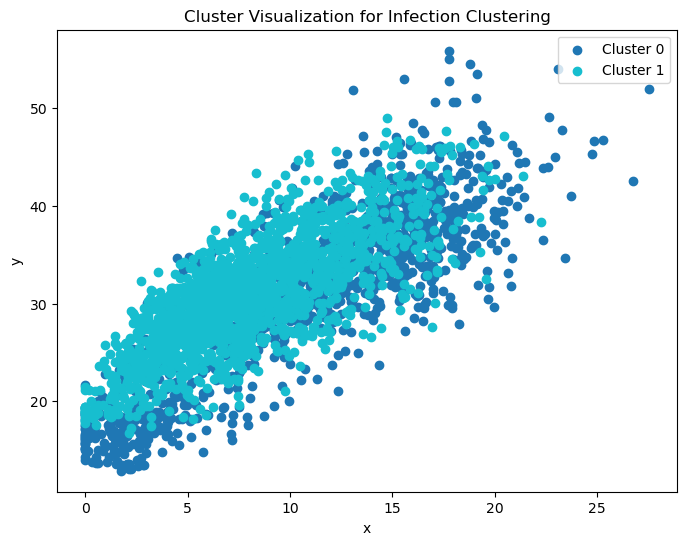

In [31]:
# Get unique cluster labels and their corresponding colors
unique_labels = np.unique(k_means.labels_)
num_clusters = len(unique_labels)

colormap = plt.cm.get_cmap('tab10', num_clusters)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter_plots = []


for i in range(num_clusters):
    cluster_points = Clus_dataSet[k_means_labels == i]
    cluster_labels = np.array(k_means.labels_)
    scatter_plot = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colormap(i)], label=f'Cluster {i}')
    #scatter_plots.append(scatter_plot)
    
#     for j in range(len(cluster_points)):
#         plt.annotate(cluster_labels[j], (cluster_points[j, 0], cluster_points[j, 1]), fontsize=8)

    scatter_plots.append(scatter_plot)
    

plt.title('Cluster Visualization for Infection Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=scatter_plots, loc='upper right')
# plt.show()
# plt.savefig('SmearClusteringPts.png', dpi=300, transparent=False)

In [32]:
# Define the metrics which require only the true labels and estimator
# labels
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

print(f"1. Homogeneity: {metrics.homogeneity_score(labels, k_means.labels_):.3f}")
print(f"2. Completeness: {metrics.completeness_score(labels, k_means.labels_):.3f}")
print(f"3. V-measure: {metrics.v_measure_score(labels, k_means.labels_):.3f}")
print(f"4. Adjusted Rand Index: {metrics.adjusted_rand_score(labels, k_means.labels_):.3f}")
print(
    "5. Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels, k_means.labels_):.3f}"
)
print(f"6. Silhouette Coefficient: {metrics.silhouette_score(Clus_dataSet, k_means.labels_):.3f}")
print(f"7. Calinski Harabasz: {metrics.calinski_harabasz_score(Clus_dataSet, k_means.labels_):.3f}")
print(f"8. Davies-bouldin score:", davies_bouldin_score(Clus_dataSet, k_means.labels_))

1. Homogeneity: 0.000
2. Completeness: 0.000
3. V-measure: 0.000
4. Adjusted Rand Index: 0.002
5. Adjusted Mutual Information: 0.000
6. Silhouette Coefficient: 0.073
7. Calinski Harabasz: 192.520
8. Davies-bouldin score: 3.825443511356292


In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,k_means.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
#len (groups[0])
f = open("InfectionCluster0_kmeans.txt", "w")
for name in groups[0]:
    f.write(name)
    f.write("\n")
f.close()

In [ ]:
#len (groups[1])
f = open("InfectionCluster1_kmeans.txt", "w")
for name in groups[1]:
    f.write(name)
    f.write("\n")
f.close()

# Agglomerative Clustering

In [33]:
# For Agglomerative Clustering Visualization
Agglo = AgglomerativeClustering(n_clusters = 2)

# Fit the data to the model
Agglo.fit(Clus_dataSet)

Agglo.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [34]:
Agglo_labels = Agglo.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(Agglo_labels)))
print(len(Agglo_labels))

The list of labels of the clusters are [0 1]
3024


C:\Users\Faithgokz\AppData\Local\Temp\ipykernel_19224\2382128558.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


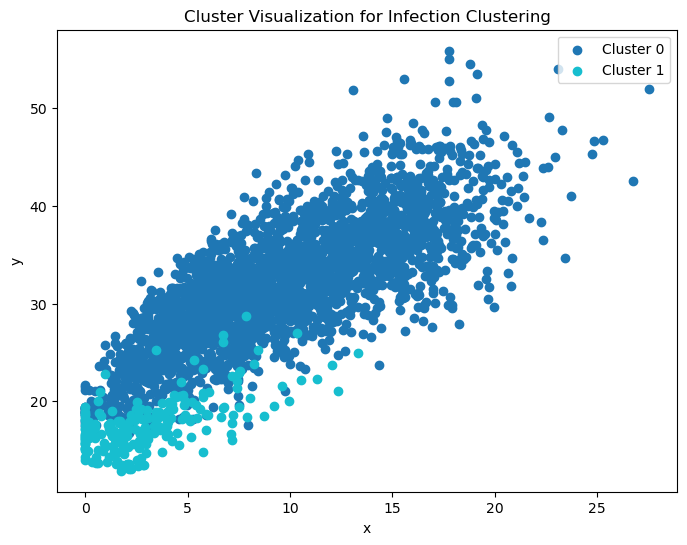

In [67]:
# Get unique cluster labels and their corresponding colors
unique_labels = np.unique(Agglo.labels_)
num_clusters = len(unique_labels)

colormap = plt.cm.get_cmap('tab10', num_clusters)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter_plots = []


for i in range(num_clusters):
    cluster_points = Clus_dataSet[Agglo_labels == i]
    cluster_labels = np.array(Agglo.labels_)
    scatter_plot = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colormap(i)], label=f'Cluster {i}')
    #scatter_plots.append(scatter_plot)
    
#     for j in range(len(cluster_points)):
#         plt.annotate(cluster_labels[j], (cluster_points[j, 0], cluster_points[j, 1]), fontsize=8)

    scatter_plots.append(scatter_plot)
    

plt.title('Cluster Visualization for Infection Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=scatter_plots, loc='upper right')
# plt.show()
# plt.savefig('SmearClusteringPts.png', dpi=300, transparent=False)

In [36]:
# Define the metrics which require only the true labels and estimator
# labels
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

print(f"1. Homogeneity: {metrics.homogeneity_score(labels, Agglo.labels_):.3f}")
print(f"2. Completeness: {metrics.completeness_score(labels, Agglo.labels_):.3f}")
print(f"3. V-measure: {metrics.v_measure_score(labels, Agglo.labels_):.3f}")
print(f"4. Adjusted Rand Index: {metrics.adjusted_rand_score(labels, Agglo.labels_):.3f}")
print(
    "5. Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels, Agglo.labels_):.3f}"
)
print(f"6. Silhouette Coefficient: {metrics.silhouette_score(Clus_dataSet, Agglo.labels_):.3f}")
print(f"7. Calinski Harabasz: {metrics.calinski_harabasz_score(Clus_dataSet, Agglo.labels_):.3f}")
print(f"8. Davies-bouldin score:", davies_bouldin_score(Clus_dataSet, Agglo.labels_))

1. Homogeneity: 0.052
2. Completeness: 0.137
3. V-measure: 0.075
4. Adjusted Rand Index: -0.035
5. Adjusted Mutual Information: 0.075
6. Silhouette Coefficient: 0.144
7. Calinski Harabasz: 144.811
8. Davies-bouldin score: 2.2949993039101453


In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,Agglo.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
#len (groups[0])
f = open("InfectionCluster0_Agglo.txt", "w")
for name in groups[0]:
    f.write(name)
    f.write("\n")
f.close()

In [ ]:
#len (groups[1])
f = open("InfectionCluster1_Agglo.txt", "w")
for name in groups[1]:
    f.write(name)
    f.write("\n")
f.close()

# Gaussian Mixture Clustering

In [37]:
Mix = mixture.GaussianMixture(n_components = 2, covariance_type="full")
Mix_Clust = Mix.fit(Clus_dataSet)

Mix.labels_ = Mix.predict(Clus_dataSet)

In [38]:
Mix_labels = Mix.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(Agglo_labels)))
print(len(Mix_labels))

The list of labels of the clusters are [0 1]
3024


C:\Users\Faithgokz\AppData\Local\Temp\ipykernel_19224\3158605088.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


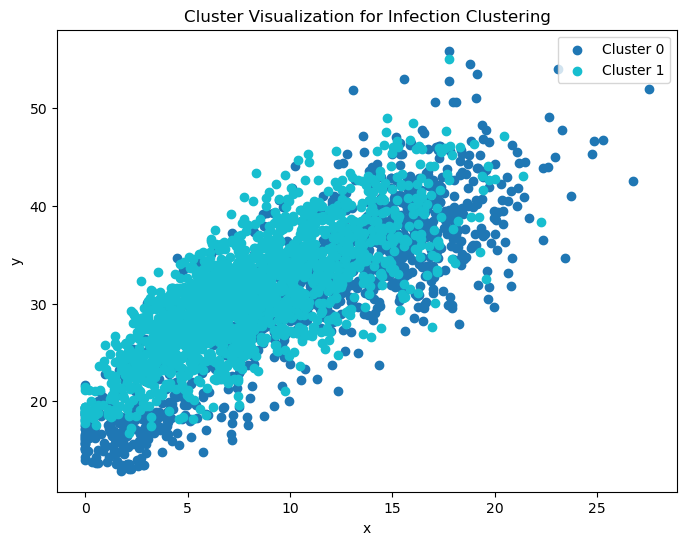

In [66]:
# Get unique cluster labels and their corresponding colors
unique_labels = np.unique(Mix.labels_)
num_clusters = len(unique_labels)

colormap = plt.cm.get_cmap('tab10', num_clusters)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter_plots = []


for i in range(num_clusters):
    cluster_points = Clus_dataSet[Mix_labels == i]
    cluster_labels = np.array(Mix.labels_)
    scatter_plot = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colormap(i)], label=f'Cluster {i}')
    #scatter_plots.append(scatter_plot)
    
#     for j in range(len(cluster_points)):
#         plt.annotate(cluster_labels[j], (cluster_points[j, 0], cluster_points[j, 1]), fontsize=8)

    scatter_plots.append(scatter_plot)
    

plt.title('Cluster Visualization for Infection Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=scatter_plots, loc='upper right')
# plt.show()
# plt.savefig('SmearClusteringPts.png', dpi=300, transparent=False)

In [40]:
# Define the metrics which require only the true labels and estimator
# labels
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

print(f"1. Homogeneity: {metrics.homogeneity_score(labels, Mix.labels_):.3f}")
print(f"2. Completeness: {metrics.completeness_score(labels, Mix.labels_):.3f}")
print(f"3. V-measure: {metrics.v_measure_score(labels, Mix.labels_):.3f}")
print(f"4. Adjusted Rand Index: {metrics.adjusted_rand_score(labels, Mix.labels_):.3f}")
print(
    "5. Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels, Mix.labels_):.3f}"
)
print(f"6. Silhouette Coefficient: {metrics.silhouette_score(Clus_dataSet, Mix.labels_):.3f}")
print(f"7. Calinski Harabasz: {metrics.calinski_harabasz_score(Clus_dataSet, Mix.labels_):.3f}")
print(f"8. Davies-bouldin score:", davies_bouldin_score(Clus_dataSet, Mix.labels_))

1. Homogeneity: 0.000
2. Completeness: 0.000
3. V-measure: 0.000
4. Adjusted Rand Index: 0.004
5. Adjusted Mutual Information: 0.000
6. Silhouette Coefficient: 0.073
7. Calinski Harabasz: 192.473
8. Davies-bouldin score: 3.8029307678213256


In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,Mix.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
#len (groups[0])
f = open("InfectionCluster0_Mix.txt", "w")
for name in groups[0]:
    f.write(name)
    f.write("\n")
f.close()

In [ ]:
#len (groups[1])
f = open("InfectionCluster1_Mix.txt", "w")
for name in groups[1]:
    f.write(name)
    f.write("\n")
f.close()

# Spectral Clustering

In [41]:
Spec = SpectralClustering(n_clusters = 2, n_jobs = -1, eigen_solver='arpack',
                                           affinity="nearest_neighbors")
Spec_Clust = Spec.fit(Clus_dataSet)

In [42]:
Spec_labels = Spec_Clust.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(Spec_labels)))
len (Spec_labels)

The list of labels of the clusters are [0 1]


3024

C:\Users\Faithgokz\AppData\Local\Temp\ipykernel_19224\254850249.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


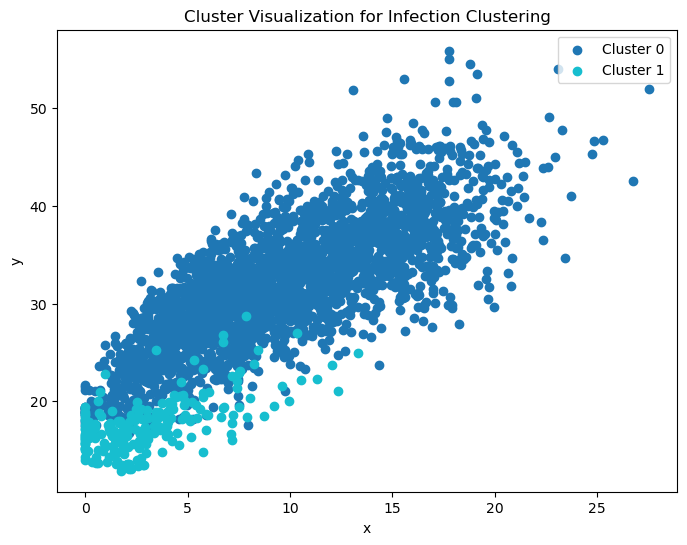

In [65]:
# Get unique cluster labels and their corresponding colors
unique_labels = np.unique(Spec_Clust.labels_)
num_clusters = len(unique_labels)

colormap = plt.cm.get_cmap('tab10', num_clusters)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter_plots = []


for i in range(num_clusters):
    cluster_points = Clus_dataSet[Spec_labels == i]
    cluster_labels = np.array(Spec.labels_)
    scatter_plot = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colormap(i)], label=f'Cluster {i}')
    #scatter_plots.append(scatter_plot)
    
#     for j in range(len(cluster_points)):
#         plt.annotate(cluster_labels[j], (cluster_points[j, 0], cluster_points[j, 1]), fontsize=8)

    scatter_plots.append(scatter_plot)
    

plt.title('Cluster Visualization for Infection Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=scatter_plots, loc='upper right')
# plt.show()
# plt.savefig('SmearClusteringPts.png', dpi=300, transparent=False)

In [44]:
# Define the metrics which require only the true labels and estimator
# labels
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

print(f"1. Homogeneity: {metrics.homogeneity_score(labels, Spec.labels_):.3f}")
print(f"2. Completeness: {metrics.completeness_score(labels, Spec.labels_):.3f}")
print(f"3. V-measure: {metrics.v_measure_score(labels, Spec.labels_):.3f}")
print(f"4. Adjusted Rand Index: {metrics.adjusted_rand_score(labels, Spec.labels_):.3f}")
print(
    "5. Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels, Spec.labels_):.3f}"
)
print(f"6. Silhouette Coefficient: {metrics.silhouette_score(Clus_dataSet, Spec.labels_):.3f}")
print(f"7. Calinski Harabasz: {metrics.calinski_harabasz_score(Clus_dataSet, Spec.labels_):.3f}")
print(f"8. Davies-bouldin score:", davies_bouldin_score(Clus_dataSet, Spec.labels_))

1. Homogeneity: 0.052
2. Completeness: 0.137
3. V-measure: 0.075
4. Adjusted Rand Index: -0.035
5. Adjusted Mutual Information: 0.075
6. Silhouette Coefficient: 0.144
7. Calinski Harabasz: 144.811
8. Davies-bouldin score: 2.2949993039101453


In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,Spec.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
#len (groups[0])
f = open("InfectionCluster0_Spec.txt", "w")
for name in groups[0]:
    f.write(name)
    f.write("\n")
f.close()

In [ ]:
#len (groups[1])
f = open("InfectionCluster1_Spec.txt", "w")
for name in groups[1]:
    f.write(name)
    f.write("\n")
f.close()

## K-medoid Clustering - PAM

In [56]:
# pip install scikit-learn-extra

In [58]:
import numpy as np
from sklearn_extra.cluster import KMedoids

model_KM = KMedoids(n_clusters=2)
KM_Clust = model_KM.fit(Clus_dataSet)
print("Labels :", KM_Clust.labels_)
print("Cluster centers  :", KM_Clust.cluster_centers_)

Labels : [1 0 0 ... 1 1 1]
Cluster centers  : [[14.068907  38.4076     0.        ...  0.        12.274167   0.       ]
 [ 5.377858  27.073786   2.3019335 ...  0.        15.7252245  0.       ]]


In [59]:
KM_labels = KM_Clust.labels_ #List of labels of each dataset
print("The list of labels of the clusters are " + str(np.unique(KM_labels)))
len (KM_labels)

The list of labels of the clusters are [0 1]


3024

C:\Users\Faithgokz\AppData\Local\Temp\ipykernel_19224\2691567979.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', num_clusters)


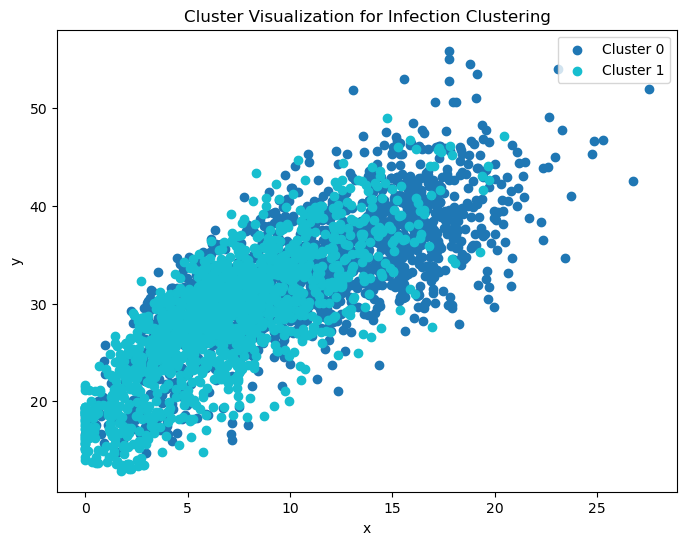

In [60]:
# Get unique cluster labels and their corresponding colors
unique_labels = np.unique(KM_Clust.labels_)
num_clusters = len(unique_labels)

colormap = plt.cm.get_cmap('tab10', num_clusters)

# Visualize clusters
plt.figure(figsize=(8, 6))
scatter_plots = []


for i in range(num_clusters):
    cluster_points = Clus_dataSet[KM_labels == i]
    cluster_labels = np.array(KM_Clust.labels_)
    scatter_plot = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colormap(i)], label=f'Cluster {i}')
    #scatter_plots.append(scatter_plot)
    
#     for j in range(len(cluster_points)):
#         plt.annotate(cluster_labels[j], (cluster_points[j, 0], cluster_points[j, 1]), fontsize=8)

    scatter_plots.append(scatter_plot)
    

plt.title('Cluster Visualization for Infection Clustering')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=scatter_plots, loc='upper right')
# plt.show()
# plt.savefig('SmearClusteringPts.png', dpi=300, transparent=False)

In [64]:
# Define the metrics which require only the true labels and estimator
# labels
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score

print(f"1. Homogeneity: {metrics.homogeneity_score(labels, KM_Clust.labels_):.3f}")
print(f"2. Completeness: {metrics.completeness_score(labels, KM_Clust.labels_):.3f}")
print(f"3. V-measure: {metrics.v_measure_score(labels, KM_Clust.labels_):.3f}")
print(f"4. Adjusted Rand Index: {metrics.adjusted_rand_score(labels, KM_Clust.labels_):.3f}")
print(
    "5. Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels, KM_Clust.labels_):.3f}"
)
print(f"6. Silhouette Coefficient: {metrics.silhouette_score(Clus_dataSet, KM_Clust.labels_):.3f}")
print(f"7. Calinski Harabasz: {metrics.calinski_harabasz_score(Clus_dataSet, KM_Clust.labels_):.3f}")
print(f"8. Davies-bouldin score:", davies_bouldin_score(Clus_dataSet, KM_Clust.labels_))

1. Homogeneity: 0.006
2. Completeness: 0.006
3. V-measure: 0.006
4. Adjusted Rand Index: 0.008
5. Adjusted Mutual Information: 0.006
6. Silhouette Coefficient: 0.039
7. Calinski Harabasz: 123.594
8. Davies-bouldin score: 4.882864599671081


In [61]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,KM_Clust.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [62]:
#len (groups[0])
f = open("InfectionCluster0_Medoids.txt", "w")
for name in groups[0]:
    f.write(name)
    f.write("\n")
f.close()

In [63]:
#len (groups[1])
f = open("InfectionCluster1_Medoids.txt", "w")
for name in groups[1]:
    f.write(name)
    f.write("\n")
f.close()

In [39]:
# view_cluster(0)